# Sample Model to Predict Taxi Cab Trip Time

##### This notebook will contain the model script to generate predictions for trip time to be used with the Kubeflow pipelines established. Any model can replace this one to illustrate the functionality of the MLOPS environment.

In [1]:
##load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from io import BytesIO
from google.cloud import storage
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
##connect to training dataset
storage_client = storage.Client()
bucket = storage_client.get_bucket('mlops_model_input')
file = '/data_input/Taxi_Trips_3mo.csv'
blob = bucket.blob(file)
path = "gs://mlops_model_input" + file
df = pd.read_csv(path)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
##print the top 5 records of imported dataset
df.head(2)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,"1,140",6.4,NaN,NaN,28.0,6.0,...,0.0,25.35,Credit Card,Medallion Leasin,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,3adf277e43154ac0cd099c7bb7137f75dcfded95,d24314a66ebc6319a50cc335d6896612b845ca15f702ee...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,420,1.3,NaN,NaN,8.0,8.0,...,0.0,7.00,Cash,Top Cab Affiliation,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


In [5]:
df['Trip Start Timestamp'].isna().sum()

0

In [6]:
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])

In [7]:
df['start_hr'] = df['Trip Start Timestamp'].dt.hour

In [8]:
df['start_dow'] = df['Trip Start Timestamp'].dt.day_name()

Try and make pickup/dropoff string --> numeric makes no sense?

In [9]:
df.head(1).T

,0
Trip ID,3e1ac82501797e2e6cd020d2eb6a47774add503f
Taxi ID,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...
Trip Start Timestamp,2021-01-01 00:15:00
Trip End Timestamp,01/01/2021 12:30:00 AM
Trip Seconds,"1,140"
Trip Miles,6.4
Pickup Census Tract,NaN
Dropoff Census Tract,NaN
Pickup Community Area,28.0
Dropoff Community Area,6.0


In [10]:
##check dimensions of imported file
rows = df.shape[0]
cols = df.shape[1]
print(rows)
print(cols)

511131
25


#### Our Model will use and try to predict the total number of Trip Seconds and we will set that to be the dependent variable

In [11]:
#TO-DO remove any records with 0 Trip Seconds!
##remove null values!

In [12]:
x_cols = ["Pickup Centroid Latitude","Pickup Centroid Longitude", "Dropoff Centroid Longitude", 
          "Dropoff Centroid Latitude",'start_hr',
    'start_dow','Trip Miles']

In [13]:
df[x_cols+['Trip Seconds']].isna().sum()

Pickup Centroid Latitude      36571
Pickup Centroid Longitude     36571
Dropoff Centroid Longitude    59493
Dropoff Centroid Latitude     59493
start_hr                          0
start_dow                         0
Trip Miles                        2
Trip Seconds                    274
dtype: int64

In [14]:
df = df.dropna(subset=x_cols+['Trip Seconds'])

In [15]:
df['Trip Seconds'] = df['Trip Seconds'].str.replace(',','').astype(int)

In [16]:
df['Trip Seconds'] = df['Trip Seconds'].astype(int)

In [17]:
df = df.loc[df['Trip Seconds'] < 5000,:]

In [18]:
df = df[df['Trip Seconds'] > 300]

<AxesSubplot:ylabel='Frequency'>

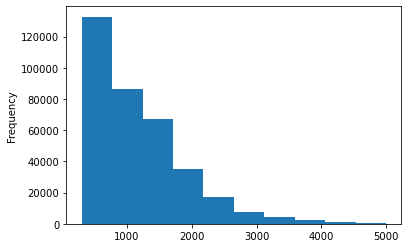

In [19]:
df['Trip Seconds'].plot.hist()

### Subset to main columns & get train_df

In [20]:
train_df = df.loc[:,x_cols+['Trip Seconds']]

In [21]:
train_df.dtypes

Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid Latitude     float64
start_hr                        int64
start_dow                      object
Trip Miles                    float64
Trip Seconds                    int64
dtype: object

In [22]:
1

1

In [23]:
categorical_columns = ['start_dow']
numeric_columns = ["Pickup Centroid Latitude","Pickup Centroid Longitude", 
                   "Dropoff Centroid Longitude", 
          "Dropoff Centroid Latitude",'start_hr','Trip Miles','Trip Seconds']

In [24]:
def preprocess(dataframe, cat_columns,numeric_columns):
    """Converts categorical features to numeric. Removes unused columns.

    Args:
      dataframe: Pandas dataframe with raw data

    Returns:
      Dataframe with preprocessed data
    """

    
    
    #1h-encode
    for col in cat_columns:
        dataframe = dataframe.join(pd.get_dummies(dataframe[col]))
        dataframe = dataframe.drop(columns=[col])
    
    # Convert integer valued (numeric) columns to floating point
    dataframe = dataframe.astype('float32')
    
        
    return dataframe

In [25]:
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [26]:
prepped_train_df = preprocess(train_df,categorical_columns,numeric_columns)

In [27]:
prepped_train_df.shape

(354902, 14)

In [28]:
prepped_train_df.head(1).T

,0
Pickup Centroid Latitude,41.874004
Pickup Centroid Longitude,-87.663521
Dropoff Centroid Longitude,-87.655998
Dropoff Centroid Latitude,41.944225
start_hr,0.000000
Trip Miles,6.400000
Trip Seconds,1140.000000
Friday,1.000000
Monday,0.000000
Saturday,0.000000


In [29]:
_LABEL_COLUMN = 'Trip Seconds'

### Hyperparameters for training ###

# This the training batch size
BATCH_SIZE = 32

# This is the number of epochs (passes over the full training data)
NUM_EPOCHS = 20

# Define learning rate.
LEARNING_RATE = .05

## Model Development Using Tensorflow

In [30]:
# Split train and test data with labels.
# The pop() method will extract (copy) and remove the label column from the dataframe
train_x, train_y = prepped_train_df, prepped_train_df.pop(_LABEL_COLUMN)

# Reshape label columns for use with tf.data.Dataset
train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))

In [31]:
train_x.dtypes

Pickup Centroid Latitude      float32
Pickup Centroid Longitude     float32
Dropoff Centroid Longitude    float32
Dropoff Centroid Latitude     float32
start_hr                      float32
Trip Miles                    float32
Friday                        float32
Monday                        float32
Saturday                      float32
Sunday                        float32
Thursday                      float32
Tuesday                       float32
Wednesday                     float32
dtype: object

In [32]:
def standardize(dataframe):
  """Scales numerical columns using their means and standard deviation to get
  z-scores: the mean of each numerical column becomes 0, and the standard
  deviation becomes 1. This can help the model converge during training.

  Args:
    dataframe: Pandas dataframe

  Returns:
    Input dataframe with the numerical columns scaled to z-scores
  """
  dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
  # Normalize numeric columns.
  for column, dtype in dtypes:
      if dtype == 'float32':
          dataframe[column] -= dataframe[column].mean()
          dataframe[column] /= dataframe[column].std()
  return dataframe


# Join train_x and eval_x to normalize on overall means and standard
# deviations. Then separate them again.
train_x = standardize(train_x)

In [33]:
train_x.head(3)

,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Longitude,Dropoff Centroid Latitude,start_hr,Trip Miles,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-1.160408,2.806463,4.199026,-0.203595,-2.898304,0.130545,2.265493,-0.429313,-0.374679,-0.323708,-0.422757,-0.423209,-0.435342
1,-0.819246,3.166057,4.601823,-0.807461,-2.898304,-0.754448,2.265493,-0.429313,-0.374679,-0.323708,-0.422757,-0.423209,-0.435342
2,-0.511540,2.973456,4.201193,0.088531,-2.898304,-0.164452,2.265493,-0.429313,-0.374679,-0.323708,-0.422757,-0.423209,-0.435342


In [34]:
def input_fn(features, labels, shuffle, num_epochs, batch_size):
  """Generates an input function to be used for model training.

  Args:
    features: numpy array of features used for training or inference
    labels: numpy array of labels for each example
    shuffle: boolean for whether to shuffle the data or not (set True for
      training, False for evaluation)
    num_epochs: number of epochs to provide the data for
    batch_size: batch size for training

  Returns:
    A tf.data.Dataset that can provide data to the Keras model for training or
      evaluation
  """
  if labels is None:
    inputs = features
  else:
    inputs = (features, labels)
  dataset = tf.data.Dataset.from_tensor_slices(inputs)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(features))

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = dataset.repeat(num_epochs)
  dataset = dataset.batch(batch_size)
  return dataset

In [35]:
# Pass a numpy array by using DataFrame.values
training_dataset = input_fn(features=train_x.values,
                    labels=train_y,
                    shuffle=True,
                    num_epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE)

In [85]:
def create_keras_model(input_dim, learning_rate):
  """Creates Keras Model for Binary Classification.

  Args:
    input_dim: How many features the input has
    learning_rate: Learning rate for training

  Returns:
    The compiled Keras model (still needs to be trained)
  """
  Dense = tf.keras.layers.Dense
  model = tf.keras.Sequential(
    [
        Dense(13, activation=tf.nn.relu, kernel_initializer='normal',
                input_shape=(input_dim,)),
        Dense(8, activation=tf.nn.relu, kernel_initializer='normal',
                input_shape=(input_dim,)),
        Dense(4, activation=tf.nn.relu, kernel_initializer='normal',
                input_shape=(input_dim,)),
        Dense(1, kernel_initializer='normal')
    ])

  # Custom Optimizer:
  # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
  #optimizer = tf.keras.optimizers.Ftrl(
     # lr=learning_rate)

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=.1,
      decay_steps=50,
      decay_rate=0.97)

  # Compile Keras model
  model.compile(
      loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

  return model

In [86]:
train_x.head(1).values

array([[-1.1604081 ,  2.8064632 ,  4.199026  , -0.20359468, -2.8983045 ,
         0.13054544,  2.2654932 , -0.4293134 , -0.37467915, -0.32370767,
        -0.42275685, -0.42320913, -0.43534166]], dtype=float32)

In [87]:
num_train_examples, input_dim = train_x.shape
print('Number of features: {}'.format(input_dim))
print('Number of examples: {}'.format(num_train_examples))

keras_model = create_keras_model(
    input_dim=input_dim,
    learning_rate=LEARNING_RATE)

Number of features: 13
Number of examples: 354902


In [88]:
history = keras_model.fit(training_dataset,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=500,
                          verbose=1)

Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 540.9328
Epoch 2/20
500/500 [==============================] - 2s 3ms/step - loss: 414.6214
Epoch 3/20
500/500 [==============================] - 2s 3ms/step - loss: 399.5412
Epoch 4/20
500/500 [==============================] - 1s 3ms/step - loss: 401.8909
Epoch 5/20
500/500 [==============================] - 2s 3ms/step - loss: 397.7583
Epoch 6/20
500/500 [==============================] - 1s 3ms/step - loss: 388.0793
Epoch 7/20
500/500 [==============================] - 2s 3ms/step - loss: 397.9095
Epoch 8/20
500/500 [==============================] - 2s 3ms/step - loss: 378.0913
Epoch 9/20
500/500 [==============================] - 1s 3ms/step - loss: 389.0878
Epoch 10/20
500/500 [==============================] - 1s 3ms/step - loss: 388.9218
Epoch 11/20
500/500 [==============================] - 2s 3ms/step - loss: 385.8056
Epoch 12/20
500/500 [==============================] - 1s 3ms/step - loss: 379.0505
E

KeyboardInterrupt: 

In [80]:
keras_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 112       
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


In [70]:
mae = round(keras_model.evaluate(train_x,train_y),0)

11091/11091 [==============================] - 21s 2ms/step - loss: 373.4281


In [72]:
mae = int(mae)

In [73]:
mae

373

In [84]:
import json
with open('my_model/model_metrics.json', 'w') as json_file:
    mae_dict = {'curr_mae':mae}
    json.dump(mae_dict, json_file)

In [ ]:
CATEGORICAL_COLUMNS+NUMERIC_COLUMNS

In [ ]:
xt_ordered = x_train[CATEGORICAL_COLUMNS+NUMERIC_COLUMNS]

In [ ]:
train_y[:10]

In [ ]:
xt_ordered.head(1).T.to_dict()[0]

In [ ]:
import json

with open('prediction_input.json', 'w') as json_file:
  for row in train_x.head(10).values.tolist():
    json.dump(row, json_file)
    json_file.write('\n')

In [ ]:
import json

jdict = {}
#with open('prediction_input.json', 'w') as json_file:
inst_ls = []
ct = 1
#inst_ls.append(xt_ordered.head(1).T.to_dict()[0])
#with open('prediction_input.json', 'w') as json_file:
    #for row in xt_ordered.head(1).values.tolist():
    #   json.dump(row, json_file)
    #    json_file.write('\n')
    
         #inst_ls.append(row)

#inst_ls.append(xt_ordered.head(1).T.to_dict()[0])#,"key":ct})    
inst_ls = [-0.1721081 ,  0.06131365, -0.01878417,  0.84623253, -2.8942175 ,
         0.27650514,  2.262631  , -0.4293633 , -0.37099934, -0.31818122,
        -0.42654246, -0.4253335 , -0.43786868]
    #ct+=1
    #json.dump(row, json_file)
    #json_file.write('\n')
    
jdict = {'instances': inst_ls}

with open('prediction_input.json', 'w') as json_file:
  json.dump(jdict, json_file)

In [ ]:
jdict

In [ ]:
xt_ordered.head(1).T.to_dict()[0]

In [ ]:
xt_ordered.head(1).values

In [ ]:
feature_spec = tf.feature_column.make_parse_example_spec(feature_columns)
print(feature_spec)
serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

In [ ]:
tf.saved_model.load("gs://taxi-mlops-demo-kubeflowpipelines-default/mlops-demo/model/1620678644/saved_model.pb")

In [ ]:
xt_ordered.head(1).values.tolist()[0]

In [ ]:
jdict

In [ ]:
xt_ordered.head(1).T.to_dict()[0]

In [ ]:
jdict

In [ ]:
## Train the model
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)
linear_est.train(train_input_fn)
#result = linear_est.evaluate(eval_input_fn)
##remove null values, the error is related to that.

In [ ]:
inputFn = tf.estimator.export.build_parsing_serving_input_receiver_fn(tf.feature_column.make_parse_example_spec(feature_columns))

modelPath = linear_est.export_saved_model('md', inputFn)

In [ ]:
importedModel = tf.saved_model.load('md/1620831681')

In [ ]:
importedModel.__dict__.keys()

In [ ]:
importedModel.variables